In [ ]:
# package configurations needed for Google Colab and potentialy on local machine
# after running this block of code, restart the session

!pip uninstall -y scikit-plot scipy
!pip install scikit-plot scipy==1.11.4
!pip install --force-reinstall scikit-plot==0.3.7 scipy==1.11.4

In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
warnings.filterwarnings('ignore')

## Load Dataset and Clean Dataset

In [3]:
# read the dataset
df = pd.read_csv("train.csv", sep = ",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592380 entries, 0 to 592379
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    592380 non-null  int64  
 1   last_price            592380 non-null  float64
 2   mid                   592380 non-null  float64
 3   opened_position_qty   419920 non-null  float64
 4   closed_position_qty   419920 non-null  float64
 5   transacted_qty        592380 non-null  float64
 6   d_open_interest       592380 non-null  int64  
 7   bid1                  592380 non-null  float64
 8   bid2                  592380 non-null  float64
 9   bid3                  592380 non-null  float64
 10  bid4                  592380 non-null  float64
 11  bid5                  592380 non-null  float64
 12  ask1                  592380 non-null  float64
 13  ask2                  592380 non-null  float64
 14  ask3                  592380 non-null  float64
 15  

In [4]:
# drop the last 50,000 rows
df = df.iloc[:-50000]

# drop the id column since it is just an index
df.drop(columns = ['id'], inplace = True)

# rename column name
df.rename(columns = {'opened_position_qty ': 'opened_position_qty'}, inplace = True)

In [5]:
# check for missing data
df.isnull().sum()

last_price                  0
mid                         0
opened_position_qty    159423
closed_position_qty    159423
transacted_qty              0
d_open_interest             0
bid1                        0
bid2                        0
bid3                        0
bid4                        0
bid5                        0
ask1                        0
ask2                        0
ask3                        0
ask4                        0
ask5                        0
bid1vol                     0
bid2vol                     0
bid3vol                     0
bid4vol                     0
bid5vol                     0
ask1vol                     0
ask2vol                     0
ask3vol                     0
ask4vol                     0
ask5vol                     0
y                           0
dtype: int64

In [5]:
# replace data points based on surrounding data values
# linear assumes a 'straight line' from the previous data points to the next one. may be less accurate if we have a bunch of missing data points in a row
df['opened_position_qty'].interpolate(method='linear', inplace=True)
df['closed_position_qty'].interpolate(method='linear', inplace=True)

In [7]:
# check for missing data
df.isnull().sum()

last_price             0
mid                    0
opened_position_qty    1
closed_position_qty    1
transacted_qty         0
d_open_interest        0
bid1                   0
bid2                   0
bid3                   0
bid4                   0
bid5                   0
ask1                   0
ask2                   0
ask3                   0
ask4                   0
ask5                   0
bid1vol                0
bid2vol                0
bid3vol                0
bid4vol                0
bid5vol                0
ask1vol                0
ask2vol                0
ask3vol                0
ask4vol                0
ask5vol                0
y                      0
dtype: int64

In [8]:
df.head()

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid2vol,bid3vol,bid4vol,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y
0,3842.4,3842.6,NaN,NaN,103.0,0,3842.4,3842.0,3841.8,3841.0,...,1,6,14,6,6,1,1,10,2,1
1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,3842.0,...,6,11,1,6,1,4,4,1,13,0
2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,3843.0,...,1,4,21,12,1,16,10,4,9,0
3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,3842.0,...,13,12,2,4,2,7,1,2,11,1
4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,3841.8,...,12,2,2,4,1,3,1,11,15,1


In [6]:
# remove the first row which is the only one with missing data now
df = df.iloc[1:]

## Feature Engineering

In [7]:
# Feature Engineering with midprice and Open/Close positions

# Feature: Ratio of opened_position_qty to closed_position_qty
df['open_close_ratio'] = df['opened_position_qty'] / (df['closed_position_qty'] + 1e-6)  # Add small value to avoid division by zero

# Feature: Difference between midprice and last price
df['mid_last_diff'] = df['mid'] - df['last_price']

# Feature: Total bid volume compared to midprice
total_bid_vol = df['bid1vol'] + df['bid2vol'] + df['bid3vol'] + df['bid4vol'] + df['bid5vol']
total_ask_vol = df['ask1vol'] + df['ask2vol'] + df['ask3vol'] + df['ask4vol'] + df['ask5vol']

# ratio between bid/ask volume and the midprice:
df['bid_ask_vol_ratio'] = total_bid_vol / (total_ask_vol + 1e-6)  # Add small value to avoid division by zero

## Preview Clean Data

In [11]:
df.describe()

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y,open_close_ratio,mid_last_diff,bid_ask_vol_ratio
count,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,...,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,542379.000000,5.423790e+05,542379.000000,542379.000000
mean,3954.533795,3954.533236,1.226651,1.760397,2.368866,-0.095653,3954.342101,3954.105260,3953.882489,3953.662123,...,6.026555,3.901796,4.948324,5.360373,5.669381,5.994170,0.354608,2.215201e+05,-0.000559,1.300719
std,76.290754,76.290037,1.974800,2.317912,3.776659,2.348708,76.285531,76.280009,76.274652,76.268426,...,6.312679,4.505113,5.455593,5.951042,6.511757,6.991134,0.478395,7.365535e+05,0.210798,1.026004
min,3812.000000,3812.100000,0.000000,0.000000,0.000000,-171.000000,3811.800000,3811.600000,3811.400000,3811.200000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000e+00,-2.000000,0.042857
25%,3894.600000,3894.700000,0.000000,1.000000,0.000000,-1.000000,3894.400000,3894.200000,3894.000000,3893.800000,...,2.000000,1.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000e+00,-0.100000,0.625000
50%,3970.000000,3970.000000,1.000000,1.000000,1.000000,0.000000,3969.800000,3969.600000,3969.400000,3969.200000,...,4.000000,2.000000,3.000000,4.000000,4.000000,4.000000,0.000000,4.999998e-01,0.000000,1.000000
75%,4024.800000,4024.700000,1.500000,2.000000,3.000000,1.000000,4024.600000,4024.200000,4024.000000,4023.800000,...,8.000000,5.000000,6.000000,7.000000,7.000000,7.000000,1.000000,1.999996e+00,0.100000,1.647059
max,4082.800000,4082.900000,80.000000,212.000000,311.000000,50.000000,4082.800000,4082.600000,4082.400000,4082.200000,...,120.000000,130.000000,132.000000,133.000000,134.000000,135.000000,1.000000,2.400000e+07,2.600000,22.249997


In [12]:
df.head()

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y,open_close_ratio,mid_last_diff,bid_ask_vol_ratio
1,3842.8,3843.4,6.0,49.0,55.0,-43,3843.0,3842.8,3842.4,3842.0,...,6,1,4,4,1,13,0,0.122449,0.6,1.347826
2,3844.0,3844.3,7.0,77.0,84.0,-69,3843.8,3843.6,3843.2,3843.0,...,12,1,16,10,4,9,0,0.090909,0.3,1.025000
3,3843.8,3843.4,3.0,34.0,37.0,-30,3843.0,3842.8,3842.4,3842.0,...,4,2,7,1,2,11,1,0.088235,-0.4,1.782609
4,3843.2,3843.1,3.0,38.0,41.0,-35,3842.8,3842.4,3842.0,3841.8,...,4,1,3,1,11,15,1,0.078947,-0.1,1.096774
5,3843.6,3844.2,12.0,17.0,29.0,-5,3843.8,3843.4,3843.2,3843.0,...,17,1,12,15,10,3,0,0.705882,0.6,0.658537


In [13]:
df.tail()

,last_price,mid,opened_position_qty,closed_position_qty,transacted_qty,d_open_interest,bid1,bid2,bid3,bid4,...,bid5vol,ask1vol,ask2vol,ask3vol,ask4vol,ask5vol,y,open_close_ratio,mid_last_diff,bid_ask_vol_ratio
542375,4044.2,4044.2,0.5,1.5,0.0,0,4044.0,4043.8,4043.4,4043.2,...,4,2,3,2,1,1,1,0.333333,0.0,1.888889
542376,4044.4,4044.2,1.0,1.0,2.0,0,4044.0,4043.8,4043.4,4043.2,...,4,1,3,1,22,1,0,0.999999,-0.2,0.607143
542377,4044.4,4044.4,3.0,2.0,5.0,1,4044.2,4043.8,4043.4,4043.2,...,4,3,1,22,1,2,0,1.499999,0.0,0.448276
542378,4044.4,4044.2,0.0,9.0,9.0,-8,4043.8,4043.4,4043.2,4043.0,...,3,3,1,22,1,2,0,0.000000,-0.2,0.517241
542379,4044.4,4044.2,0.0,9.0,0.0,0,4044.0,4043.8,4043.4,4043.2,...,4,1,3,1,22,1,0,0.000000,-0.2,0.500000


## Split the Dataset for Training and Testing

In [8]:
# predictors
X = df.drop(columns = ['y'])

# response variable
y = df['y']

# spilt the dataset into training and testing with a 80/20 spilt with a random state
X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.2, random_state = 123)

## Random Forest Model

### Fitting a Random Forest

Note that it takes at least 90 minutes in Google Colab in a standard runtime for the Random Forest to compile.



In [15]:
# parameters for hypertuning
parameters = [{'n_estimators': [100],
               'max_features': ['sqrt'],
               'max_depth': [7, 9, 12, 16],
               'criterion': ['gini', 'entropy']}]

# hypertune for random froest
GridSearch_RandomForest = GridSearchCV(estimator = RandomForestClassifier(random_state = 123), param_grid = parameters, scoring = 'accuracy', cv = 5)

# fit a random forest
GridSearch_RandomForest.fit(X_train, y_train)
print(GridSearch_RandomForest.best_params_)

# score for the best model
print(GridSearch_RandomForest.score(X_train, y_train))


{'criterion': 'gini', 'max_depth': 16, 'max_features': 'sqrt', 'n_estimators': 100}
0.7594162750660862


### Predicted Data from Random Forest

In [16]:
prediction_RandomForest = GridSearch_RandomForest.predict(X_test)
prediction_probs_RandomForest = GridSearch_RandomForest.predict_proba(X_test)

In [17]:
print('Accuracy: ', accuracy_score(y_test, prediction_RandomForest))

Accuracy:  0.6670968693535897


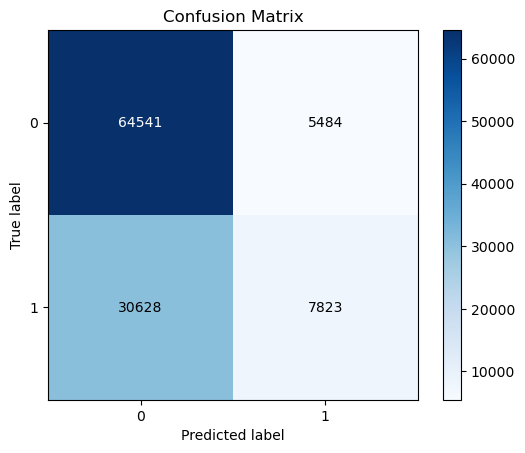

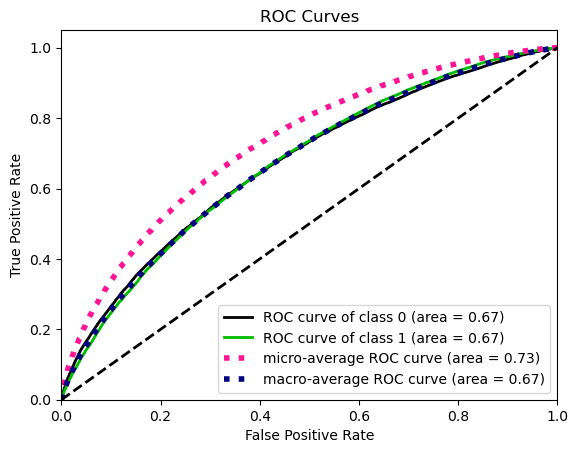

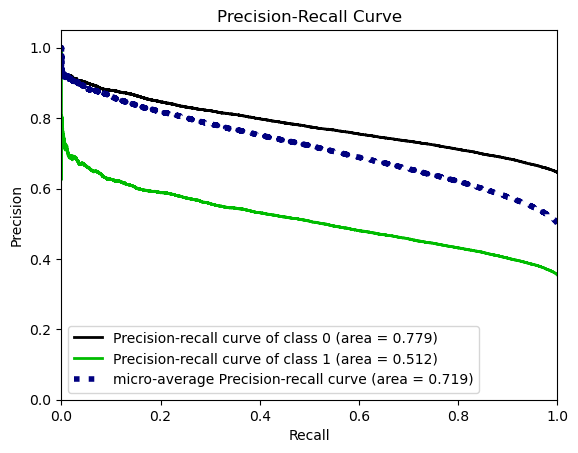

In [18]:
skplt.metrics.plot_confusion_matrix(y_test, prediction_RandomForest)
skplt.metrics.plot_roc(y_test, prediction_probs_RandomForest)
skplt.metrics.plot_precision_recall_curve(y_test, prediction_probs_RandomForest)
plt.show()

## Support Vector Machine

In [9]:
# reduce the predictors to only consider open_close_ratio, mid_last_diff, and bid_ask_vol_ratio
X_train_reduced = X_train[['open_close_ratio', 'mid_last_diff', 'bid_ask_vol_ratio']]
X_test_reduced = X_test[['open_close_ratio', 'mid_last_diff', 'bid_ask_vol_ratio']]

# scale the predictors
scaler = StandardScaler()
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.fit_transform(X_test_reduced)

### Fitting a SVM Model

Note that SVM takes at least 5 hours.

In [10]:
# fit a svm
svm_model = SVC(kernel='linear', class_weight='balanced', probability = True)
svm_model.fit(X_train_reduced_scaled, y_train)

SVC(class_weight='balanced', kernel='linear', probability=True)

### Predicted Data from SVM

Note that this takes about 14 minutes.

In [11]:
prediction_SVM = svm_model.predict(X_test_reduced_scaled)
prediction_probs_SVM = svm_model.predict_proba(X_test_reduced_scaled)

In [12]:
print('Accuracy: ', accuracy_score(y_test, prediction_SVM))

Accuracy:  0.5795659869464214


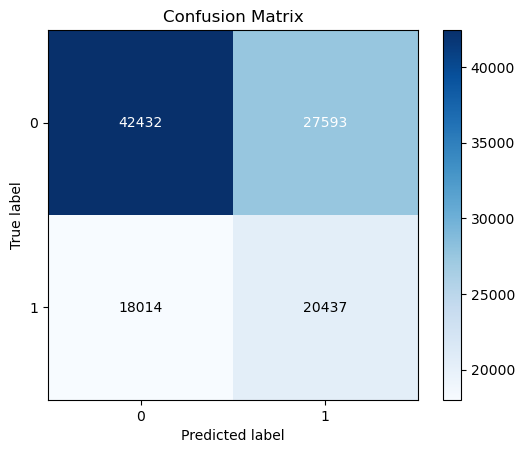

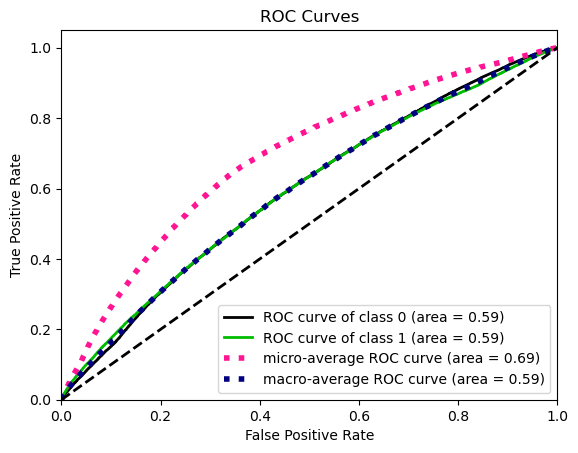

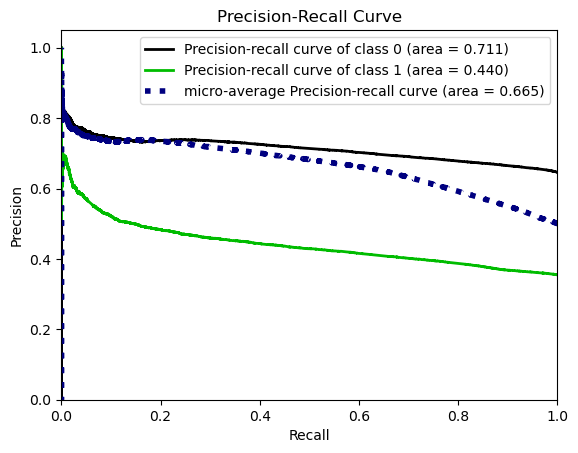

In [13]:
skplt.metrics.plot_confusion_matrix(y_test, prediction_SVM)
skplt.metrics.plot_roc(y_test, prediction_probs_SVM)
skplt.metrics.plot_precision_recall_curve(y_test, prediction_probs_SVM)
plt.show()